In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.vectorized as sv
import seaborn as sns
import pandas as pd
import glob
import pickle

In [2]:
def fill_results_from_csv(result_array, case, cond):
    """
    Fill the results array with the results from the csv files
    """
    # Load the results from the csv files
    csv_dir = f'output_data/cs_fraction_{case}_gas{cond}/'
    for file in os.listdir(csv_dir):
        result = np.loadtxt(csv_dir + file, delimiter=',')
        result_array.loc[{'x': result[0], 'y': result[1]}] = result[2]
    return result_array

In [3]:
def fill_results_from_pickle(result_array, case, cond):
    """
    Fill the results array with the results from the pickle files
    """
    pickle_path = f'output_data/{case.lower()}/{case.lower()}_gas{cond}*.pickle'
    for file in glob.glob(pickle_path):
        with open(file, 'rb') as f:
            result_data = pickle.load(f)
        f.close()

        storage_capacity = result_data["component results"]["Optimal Capacity [MW]"].loc[("Store", "molten-salt-store glasspoint")]
        cs_capacity = result_data["component results"]["Optimal Capacity [MW]"].loc[("Generator", "csp glasspoint")]

        # Extract the x and y coordinates from the file name
        x = float(file.split('_')[-2])
        y = float(file.split('_')[-1].split('.')[0])
        # Ratio of storage capacity to csp capacity
        if not cs_capacity == 0:
            ratio = cs_capacity # storage_capacity / 
        else:
            ratio = np.nan
        result_array.loc[{'x': result_array.x.sel(x=x, method="nearest"), 
                  'y': result_array.y.sel(y=y, method="nearest")}] = ratio
    return result_array


In [4]:
# Create result map

def store_results_map(case, cond, variable):
    """
    Store the results of the breakeven cost analysis in a netcdf file.
    """
    if not os.path.exists(f'output_data/{variable}_{case}_gas{cond}.nc'):
        cap_fac = xr.open_dataset('concentrated_solar_capacity_factors/atlite_default_global/world_csp_CF_timeseries_2023.nc')

        # Create xarray to store results
        result_array = xr.DataArray(
            data=None,
            dims=['x', 'y'],
            coords={
                'x': cap_fac.x,
                'y': cap_fac.y},
            name='breakeven_cost')
        
        if variable=='cs_fraction':
            result_array = fill_results_from_csv(result_array, case, cond)
        elif variable=='storage_ratio':
            result_array = fill_results_from_pickle(result_array, case, cond)

        # Remove existing file
        if os.path.exists(f'output_data/cs_fraction_{case}_gas{cond}.nc'):
            os.remove(f'output_data/cs_fraction_{case}_gas{cond}.nc')
        # Save the results to a netcdf file
        result_array.to_netcdf(f'output_data/{variable}_{case}_gas{cond}.nc')

In [5]:
def get_world():
    """
    Get world map from shapefile.
    """
    # Load the world shapefile
    world = gpd.read_file('input_files/ne_110m_admin_0_countries.shp')
    # Drop Antarctica by excluding everyhting below -60 latitude
    world = world[world.geometry.centroid.y > -60]

    return world


In [6]:
def mask_data_world(data, world):
    """
    Mask data with world shapefile.
    """
    # Extract the geometry from the GeoSeries (use union_all if there are multiple polygons)
    region_geom = world.geometry.union_all() if len(world) > 1 else world.geometry.iloc[0]

    # Get the grid of coordinates (lon, lat) from the xarray DataArray
    lon, lat = np.meshgrid(data['x'], data['y'], indexing='ij')

    # Use shapely's vectorized.contains to create a mask for points within the region
    mask = sv.contains(region_geom, lon, lat)

    # Apply the mask to the dataset DataArray
    masked_data = data.where(mask)

    return masked_data

In [7]:
def plot_result_map(file_path, case_name, title, cmap_label):
    """
    Plot the world map with data.
    """

    dataset = xr.open_dataset(file_path)
    dataset.close()
    # Reindex the dataset to 0.25 degree resolution
    dataset = dataset.reindex(x=np.arange(-180, 180.25, 0.25), y=np.arange(-57, 85.25, 0.25), method='nearest')

    # Get world map
    world = get_world()

    # Mask dataset with world map
    masked_dataset = mask_data_world(dataset, world)

    # Plot the result with 1 step on x axis is the same as 1 step on y axis
    # use log scale for colorbar
    aspect_ratio = (dataset['x'].max()-dataset['x'].min())/(dataset['y'].max()-dataset['y'].min())
    if 'fraction' in cmap_label:
        cmap = 'viridis'
        label = 'fraction'
    else:
        cmap = 'inferno'
        label = 'time'
    masked_dataset[f'breakeven_cost'].plot(x='x', y='y', aspect=aspect_ratio, size=5, cmap=cmap, cbar_kwargs={'label': cmap_label}, vmin=0)#, vmax=1)

    # Remove x and y labels and ticks
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().set_xlabel('')
    plt.gca().set_ylabel('')
    # Add title
    plt.gca().set_title(title)
    # Remove box around the plot
    for edge in ['top', 'right', 'bottom', 'left']:
        plt.gca().spines[edge].set_visible(False)

    # Add world map outline in light grey
    world.boundary.plot(ax=plt.gca(), color='lightgrey', linewidth=0.5)

    # Save the plot
    if not os.path.exists('figures'):
        os.makedirs('figures')
    gas_cost = title.replace("Gas cost = $", "").replace("/MWh", "")
    plt.savefig(f'figures/csp_fraction_map_{case_name}_gas{gas_cost}_{label}.jpg', bbox_inches='tight', dpi=400)


In [8]:
def compute_equal_area_bands(num_bands=10):
    """
    Compute latitudinal bands that divide the Earth's total surface area (land + ocean) equally.
    """    
    # Define latitude bins (1-degree resolution for accuracy)
    lat_bins = np.arange(-60, 90, 1)  # Cover full latitude range
    
    # Earth's total surface area in square km
    R = 6371  # Earth radius in km

    # Compute total area per latitude band using the spherical cap formula
    total_areas = []
    for i in range(len(lat_bins) - 1):
        lat_min, lat_max = np.radians(lat_bins[i]), np.radians(lat_bins[i + 1])
        strip_area = 2 * np.pi * R**2 * (np.sin(lat_max) - np.sin(lat_min))
        total_areas.append((lat_bins[i], lat_bins[i + 1], strip_area))

    # Convert to NumPy array
    total_areas = np.array(total_areas, dtype=[('lat_min', 'f4'), ('lat_max', 'f4'), ('area', 'f4')])

    # Compute cumulative total area
    total_area = total_areas['area'].sum()
    cumulative_area = np.cumsum(total_areas['area'])

    # Identify breakpoints for equal-area division
    band_edges = np.interp(
        np.linspace(0, total_area, num_bands + 1),
        cumulative_area, 
        total_areas['lat_max']
    )

    return band_edges



def plot_lat_bands(world):
    """
    Plot the world map with latitude bands.
    """
    # Compute latitude bands based on equal landmass
    band_edges = compute_equal_area_bands()
    # Group results based on computed latitude bands
    lat_bands = [(band_edges[i], band_edges[i+1]) for i in range(len(band_edges)-1)]

    # Plot the world map with latitude bands
    fig, ax = plt.subplots(figsize=(12, 6))
    world.plot(ax=ax, color='lightgrey')

    # Overlay latitudinal bands
    colors = sns.color_palette("rocket", as_cmap=True)(np.linspace(0, 1, int(len(lat_bands)/2)))
    # Set the last color to light blue with 4 numbers
    colors[-1] = (0.5, 0.5, 1, 1)
    # Mirror the colors to get the full range
    colors = [tuple(c) for c in colors]
    colors = colors[::-1] + colors

    for i, (lat_min, lat_max) in enumerate(lat_bands):
            # Clip the land polygons to the latitude band
            land_band = world.clip_by_rect(-180, lat_min, 180, lat_max)
            # Plot the landmass with the band color
            land_band.plot(ax=ax, color=colors[i])

    # Save figure
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig('figures/lat_bands.jpg', bbox_inches='tight')
    
    return lat_bands, colors


In [9]:
def calculate_lat_band_mean(lat_bands_df, masked_dataset, lat_bands, gas_cost):
        """
        Calculate the mean concentrated solar fraction for each latitudinal band and store the results in a dictionary.
        """

        # Calculate the mean cs fraction for each latitudinal band
        cs_frac_bands = [masked_dataset.sel(y=slice(lat_min, lat_max)) for lat_min, lat_max in lat_bands]

        # Concatenate north and south bands by combining the first and last band, the second and second last band, etc.
        half_n = len(cs_frac_bands) // 2
        labels = ['high-latitudes', 'mid-latitudes', 'subtropical', 'tropical', 'equatorial']
        ns_merged_bands = {}

        for i in range(half_n):
            ns_merged_bands[labels[i]] = cs_frac_bands[i].merge(cs_frac_bands[len(cs_frac_bands)-1-i])

        # Store the results in a dataframe
        add_to_df = pd.DataFrame()
        add_to_df['latitude band'] = labels
        add_to_df['mean cs fraction'] = [np.nanmean(ns_merged_bands[label]['breakeven_cost'].values) for label in labels]
        add_to_df['std cs fraction'] = [np.nanstd(ns_merged_bands[label]['breakeven_cost'].values) for label in labels]
        add_to_df['median cs fraction'] = [np.nanmedian(ns_merged_bands[label]['breakeven_cost'].values) for label in labels]

        # Compute interquartile range (IQR) while ignoring NaNs
        q1_values = [np.nanpercentile(ns_merged_bands[label]['breakeven_cost'], 25) for label in labels]
        q3_values = [np.nanpercentile(ns_merged_bands[label]['breakeven_cost'], 75) for label in labels]

        # Error bars
        add_to_df['lower_error'] = add_to_df['median cs fraction'] - q1_values
        add_to_df['upper_error'] = q3_values - add_to_df['median cs fraction']

        for label in labels:
            print(f"Mean cs fraction for {label} is {ns_merged_bands[label]['breakeven_cost'].mean().values}")
            print(f"Standard deviation cs fraction for {label} is {ns_merged_bands[label]['breakeven_cost'].std().values}")
            print(f"Median cs fraction for {label} is {ns_merged_bands[label]['breakeven_cost'].median().values}")
            print(f"10th percentile cs fraction for {label} is {np.percentile(ns_merged_bands[label]['breakeven_cost'], 10)}")
            print(f"90th percentile cs fraction for {label} is {np.percentile(ns_merged_bands[label]['breakeven_cost'], 90)}")
            print("values", ns_merged_bands[label]['breakeven_cost'])
            print("")

        add_to_df['gas cost'] = gas_cost

        # Add the results to the dataframe
        lat_bands_df = pd.concat([lat_bands_df, add_to_df])

        return lat_bands_df

In [10]:
def plot_line(lat_df, colors):
    """
    Plot the mean cs fraction for each latitudinal band vs the gas cost.
    """
    plt.figure()
    # Plot the mean cs fraction for each latitudinal band vs the gas cost with error bars
    for i, lat in enumerate(lat_df['latitude band'].unique()):
        lat_df_sub = lat_df.loc[lat_df['latitude band'] == lat]
        plt.plot(lat_df_sub['gas cost'], lat_df_sub['median cs fraction'], color=colors[i])
        plt.errorbar(lat_df_sub['gas cost'], lat_df_sub['median cs fraction'], 
                     # Errors as interquartile range
                     yerr=[lat_df_sub['lower_error'], lat_df_sub['upper_error']],
                      fmt='o', color=colors[i], markersize=4, capsize=4,label=lat)
                

    # x-axis log scale
    plt.xscale('log')

    plt.xlabel('Gas cost ($/MWh)')
    plt.ylabel('Concentrated solar fraction')
    plt.legend()

    plt.title('Median concentrated solar fraction with 10th and 90th percentile')
    plt.savefig('figures/median_cs_fraction_vs_gas_cost.jpg', bbox_inches='tight', dpi=400)

Mean cs fraction for high-latitudes is 0.0
Standard deviation cs fraction for high-latitudes is 0.0
Median cs fraction for high-latitudes is 0.0
10th percentile cs fraction for high-latitudes is nan
90th percentile cs fraction for high-latitudes is nan
values <xarray.DataArray 'breakeven_cost' (x: 144, y: 16)> Size: 18kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 1kB -178.9 -176.4 -173.9 -171.4 ... 173.6 176.1 178.6
  * y        (y) float64 128B -54.38 -51.88 -49.38 -46.88 ... 75.62 78.12 80.62

Mean cs fraction for mid-latitudes is 0.0
Standard deviation cs fraction for mid-latitudes is 0.0
Median cs fraction for mid-latitudes is 0.0
10th percentile cs fraction for mid-latitudes is nan
90th percentile cs fraction for 

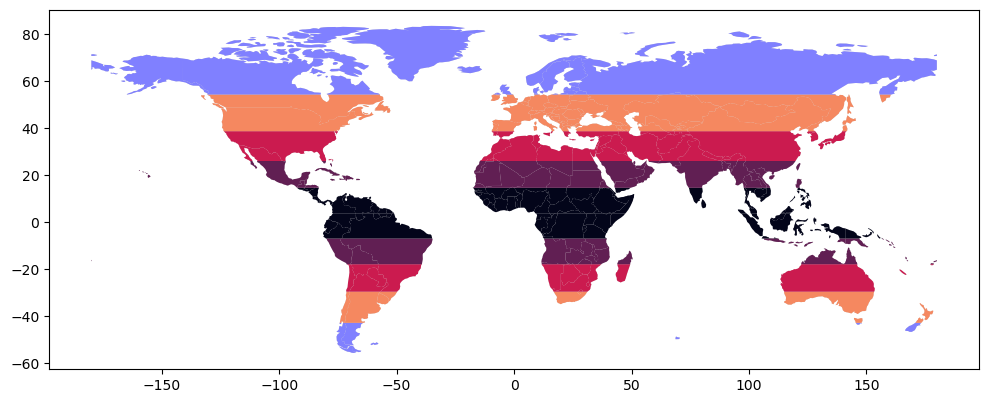

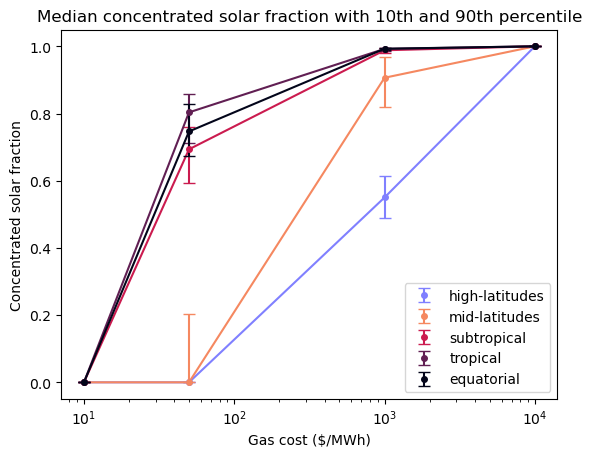

In [11]:

lat_bands, colors = plot_lat_bands(get_world())
gas_costs=[10, 50, 1000, 10000]
latitude_df = pd.DataFrame()
for gas_cost in gas_costs:
    store_results_map('CSP_storage', gas_cost, 'cs_fraction')
    masked_dataset = mask_data_world(xr.open_dataset(f'output_data/cs_fraction_CSP_storage_gas{gas_cost}.nc'), get_world())
    latitude_df = calculate_lat_band_mean(latitude_df, masked_dataset, lat_bands, gas_cost)

    # storage to generation capacity ratio
    store_results_map('CSP_storage', gas_cost, 'storage_ratio')

print(latitude_df)
plot_line(latitude_df, colors)

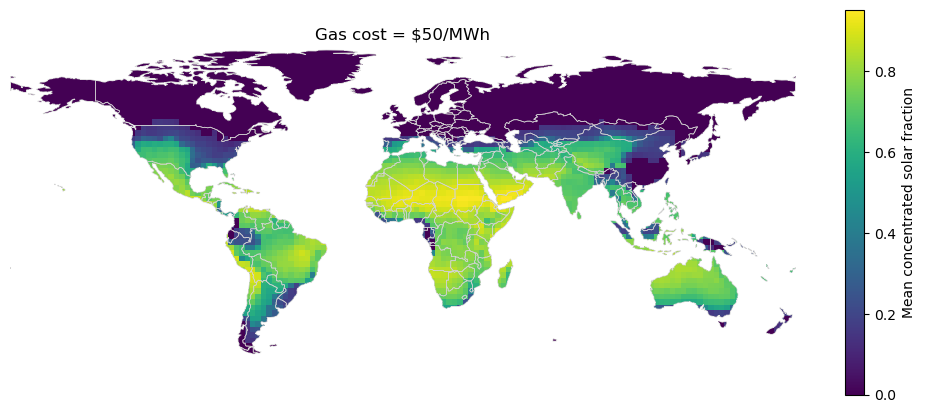

In [12]:
plot_result_map('output_data/cs_fraction_CSP_storage_gas50.nc', 'CSP_storage', 'Gas cost = $50/MWh', 'Mean concentrated solar fraction')

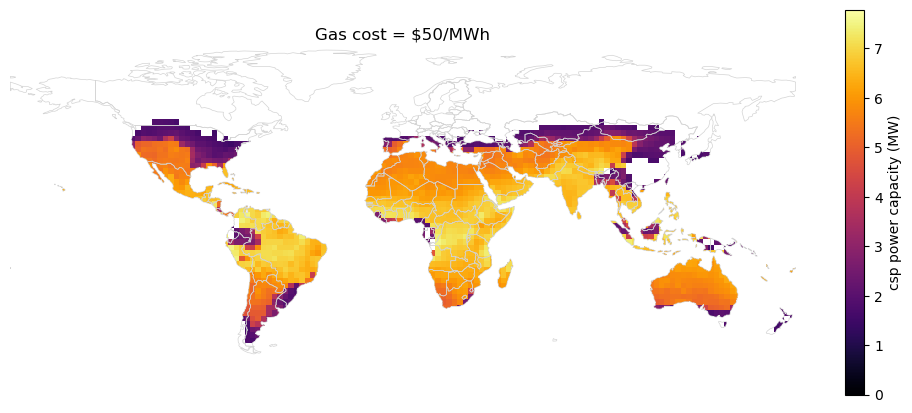

In [13]:
plot_result_map('output_data/storage_ratio_CSP_storage_gas50.nc', 'CSP_storage', 'Gas cost = $50/MWh', 'csp power capacity (MW)')

In [14]:
# Make a contour plot with the latitude dictionary, where the x-axis is the gas cost and the y-axis is the latitude band and the color is the mean concentrated solar fraction

def plot_contour(lat_dict, gas_costs):
    """
    Plot the mean cs fraction for each latitudinal band vs the gas cost.
    """
    plt.figure()
    # Plot the mean cs fraction for each latitudinal band vs the gas cost
    latitudes = list(lat_dict.keys())
    mean_cs_fraction = np.array([lat_dict[lat] for lat in latitudes])
    plt.contourf(gas_costs, latitudes, mean_cs_fraction, cmap='inferno', levels=100)
    # x-axis log scale
    plt.xscale('log')
    plt.xlabel('Gas cost ($/MWh)')
    plt.ylabel('Latitude band')
    cbar = plt.colorbar()
    # Label the colorbar
    cbar.set_label('Mean concentrated solar fraction')
    # Last tick mark is 1
    cbar.set_ticks(np.linspace(0, 1, 11))
    plt.savefig('figures/contour_plot.jpg', bbox_inches='tight', dpi=500)

In [15]:
# plot_contour(latitude_dict, gas_costs)